# Network Analysis

## Install Dependencies

In [1]:
%%capture
%pip install --upgrade basemap
%pip install --upgrade networkx

## Import Modules

In [2]:
import os
import pickle
import pandas as pd
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap as Basemap

## Mount Drive

In [3]:
import os

team_name = 'capstone-power-grid-protagonists'
colab_path = f'/content/drive/Shareddrives/{team_name}/project'
studiolab_path = f'/home/studio-lab-user/sagemaker-studiolab-notebooks/{team_name}'

try:
    # Try to mount Google Drive and set project path
    from google.colab import drive
    drive.flush_and_unmount()
    drive.mount('/content/drive')
    print('')

    root_path = colab_path
    os.chdir(root_path)

except:
    try:
        # Try to set AWS SageMaker Studio Lab project path
        root_path = studiolab_path
        os.chdir(root_path)
    
    except:
        # Set current working directory as root path
        root_path = os.getcwd()
        os.chdir(root_path)

        # If the current folder is 'notebooks', move up one level
        if root_path.endswith('/notebooks'):
            root_path = '/'.join(root_path.split('/')[:-1])
            os.chdir(root_path)
        
print('Current working directory is:')
print(os.getcwd())

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive

Current working directory is:
/content/drive/Shareddrives/capstone-power-grid-protagonists/project


## Import Data

In [4]:
# Processed data
plants = pd.read_csv('data/processed/hifld/power_plants.csv')
subs = pd.read_csv('data/processed/hifld/substations.csv')
lines = pd.read_csv('data/processed/hifld/power_lines.csv')
bas = pd.read_csv('data/processed/eia/balancing_authorities.csv')

# Models
with open('models/plants_subs_bet.pkl', 'rb') as f:
    plants_subs_bet = pickle.load(f)

with open('models/plants_bas_bet.pkl', 'rb') as f:
    plants_bas_bet = pickle.load(f)

## Network Analysis

### Nodes

In [5]:
G = nx.DiGraph()

# Add power plant nodes with attributes
plant_nodes = plants['plant_code'].astype(str).tolist()
G.add_nodes_from(plant_nodes, category='power plant')

# Add substation nodes with attributes
sub_nodes = subs['sub_code'].astype(str).tolist()
G.add_nodes_from(sub_nodes, category='substation')

# Add balancing authority nodes with attributes
ba_nodes = bas['ba_code'].astype(str).tolist()
G.add_nodes_from(ba_nodes, category='balancing authority')

### Edges

In [6]:
# Function to create edges from the dataframes
def create_edges(df, source, target, bidirectional=False):
    edge_df = df.copy()
    edge_df[target] = edge_df[target].replace('; $', '', regex=True).str.split('; ')
    edge_df = edge_df.explode(target).dropna(subset=[target])
    edge_df['edges'] = list(zip(edge_df[source].astype(str), edge_df[target].astype(str)))
    if bidirectional==True:
        edge_df['edges_2'] = list(zip(edge_df[target].astype(str), edge_df[source].astype(str)))
        return edge_df['edges'].to_list() + edge_df['edges_2'].to_list()
    else:
        return edge_df['edges'].to_list()

# Add the power plant to substation edges
plants_subs = create_edges(plants, 'plant_code', 'connected_sub')
G.add_edges_from(plants_subs)

# Add the substation to substation edges
subs_subs = create_edges(subs, 'sub_code', 'connected_sub', bidirectional=True)
G.add_edges_from(subs_subs)

# Add the power plant to balancing authority edges
plants_bas = create_edges(plants, 'plant_code', 'connected_ba')
G.add_edges_from(plants_bas)

# Add the balancing authority to balancing authority edges
bas_bas = create_edges(bas, 'ba_code', 'connected_ba', bidirectional=True)
G.add_edges_from(bas_bas)

### Map

In [7]:
# Create basemap
map = Basemap(projection='merc',
              llcrnrlon=-130, # lower left corner
              llcrnrlat=23,
              urcrnrlon=-65,  # upper right corner
              urcrnrlat=52,
              lat_ts=0,
              resolution='l',
              suppress_ticks=True)

# Function to translate lat/lon values for nodes to basemap coordinates
def coords_to_basemap(df, id, basemap=map):
    d = {}
    mx, my = basemap(df['lon'].values, df['lat'].values)
    for idx, node in enumerate(df[id]):
        d[str(node)] = (mx[idx], my[idx])
    return d

# Set positions for nodes
pos = {}
pos.update(coords_to_basemap(plants, 'plant_code'))
pos.update(coords_to_basemap(subs, 'sub_code'))
pos.update(coords_to_basemap(bas, 'ba_code'))

#### Power Plant and Substation Connections

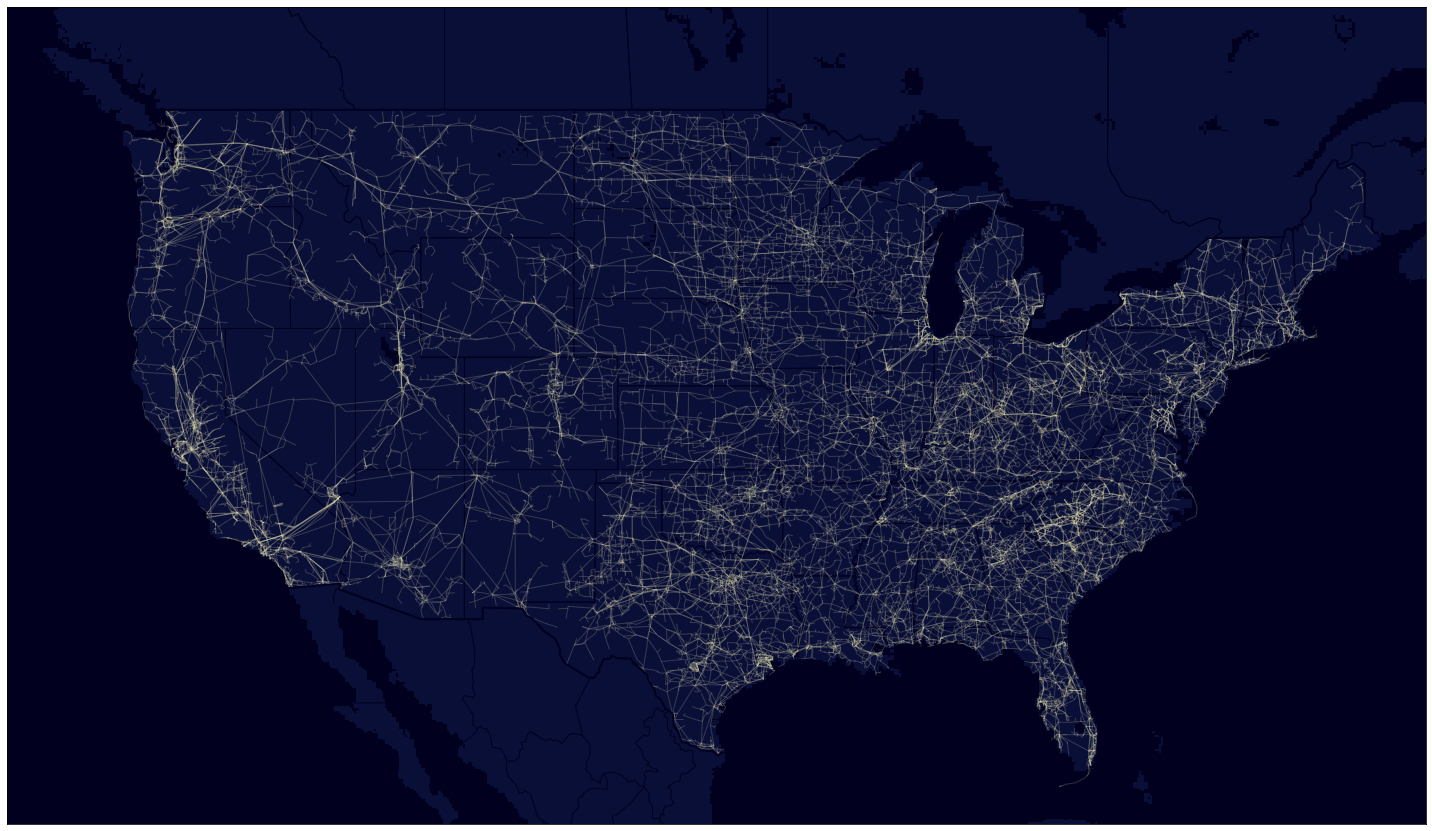

In [8]:
# Power Plants to Substations and Substations to Substations
plt.figure(figsize=(20,20))

# Map properties
map.drawlsmask(land_color='#0a0f37', ocean_color='#01001f')
map.drawcountries(color='#01001f', linewidth=2)
map.drawstates(color='#01001f', linewidth=1, zorder=1)

# Draw edges
nx.draw_networkx_edges(G, pos, edgelist=plants_subs, edge_color='#f2efbc', arrows=False, alpha=0.2)
nx.draw_networkx_edges(G, pos, edgelist=subs_subs, edge_color='#f2efbc', arrows=False, alpha=0.1)

plt.tight_layout()

In [9]:
# Create a subgraph with only Power Plants and Substations
H = G.subgraph(plant_nodes + sub_nodes + plants_subs + subs_subs)

# Calculate clustering coefficient
plants_subs_coef = nx.clustering(H)

# Calculate degree centrality
plants_subs_deg = nx.degree_centrality(H)

# The betweenness centrality for substations takes several hours to run.
# As NetworkX performs this operation using a single thread, extra compute
# power does not necessarily speed it up. Based on this, it can be run
# by commenting out the code below, but it has also been pre-calculated
# and loaded.

# plants_subs_bet = nx.betweenness_centrality(H)
# with open('models/plants_subs_bet.pkl', 'wb') as f:
#     pickle.dump(plants_subs_bet, f)

# Combine cnetwork measures with original data set
subs['deg_cent'] = subs['sub_code'].astype(str).apply(lambda x: plants_subs_deg[x])
subs['bet_cent'] = subs['sub_code'].astype(str).apply(lambda x: plants_subs_bet[x])
subs['clust_coef'] = subs['sub_code'].astype(str).apply(lambda x: plants_subs_coef[x])

In [10]:
# Top 10 by degree centrality
cols = ['sub_code', 'name', 'city', 'state', 'county', 'deg_cent']
subs.sort_values(by='deg_cent', ascending=False).head(10)[cols]

,sub_code,name,city,state,county,deg_cent
75200,306611,Newark,Fremont,CA,Alameda,0.000533
58124,201572,Terminal,Salt Lake City,UT,Salt Lake,0.000522
67195,300895,Midway,Buttonwillow,CA,Kern,0.000444
76118,305530,Tesla,Tracy,CA,Alameda,0.000422
34660,149469,Cordova,Cordova,TN,Shelby,0.000422
70965,307400,Devers,Desert Hot Springs,CA,Riverside,0.000411
32736,147494,Siegfried,Northampton,PA,Northampton,0.000400
36123,150963,Lauderdale,Fort Lauderdale,FL,Broward,0.000400
32740,147498,Sunbury,Selinsgrove,PA,Snyder,0.000389
57570,200993,Mcnary,NaN,OR,Umatilla,0.000389


In [11]:
# Top 10 by betweenness centrality
cols = ['sub_code', 'name', 'city', 'state', 'county', 'bet_cent']
subs.sort_values(by='bet_cent', ascending=False).head(10)[cols]

,sub_code,name,city,state,county,bet_cent
40035,155015,Broadford (765 Kv),Saltville,VA,Smyth,0.113122
32553,147307,Jefferson,Madison,IN,Jefferson,0.105363
33854,148634,Sweetwater,Pleasanton,NE,Custer,0.101737
39274,154233,Jacksons Ferry,Max Meadows,VA,Wythe,0.100216
36799,151644,Hanging Rock,Ironton,OH,Lawrence,0.095999
33847,148627,Moore,Hallam,NE,Lancaster,0.094072
34515,149325,Montgomery,New Florence,MO,Montgomery,0.093977
29492,143933,Cooper,Ashland,NE,Nemaha,0.093819
33029,147787,Baker,Louisa,KY,Lawrence,0.093398
37980,152860,Antioch,Wilkesboro,NC,Wilkes,0.088033


In [12]:
# Bottom 10 by clustering coefficient
cols = ['sub_code', 'name', 'city', 'state', 'county', 'clust_coef']
subs.sort_values(by='clust_coef', ascending=False).tail(10)[cols]

,sub_code,name,city,state,county,clust_coef
26999,141383,Jajome 3403,Cayey,PR,Cayey,0.0
27000,141384,Comsat 3406,Cayey,PR,Cayey,0.0
27001,141385,Las Cruces 3602,Caguas,PR,Cidra,0.0
27002,141386,Sabanera,Cidra,PR,Cidra,0.0
27003,141387,Cayey Tc,Cayey,PR,Cayey,0.0
27004,141388,Las Piedras,Las Piedras,PR,Las Piedras,0.0
27005,141389,Subestacion Escuela Ii,Ceiba,PR,Ceiba,0.0
27006,141390,Subestacion Escuela I,Ceiba,PR,Ceiba,0.0
27007,141391,Escuela Urbana,Maunabo,PR,Maunabo,0.0
77478,318153,Tap318153,Ajo,AZ,Pima,0.0


#### Power Plants and Balancing Authority Connections

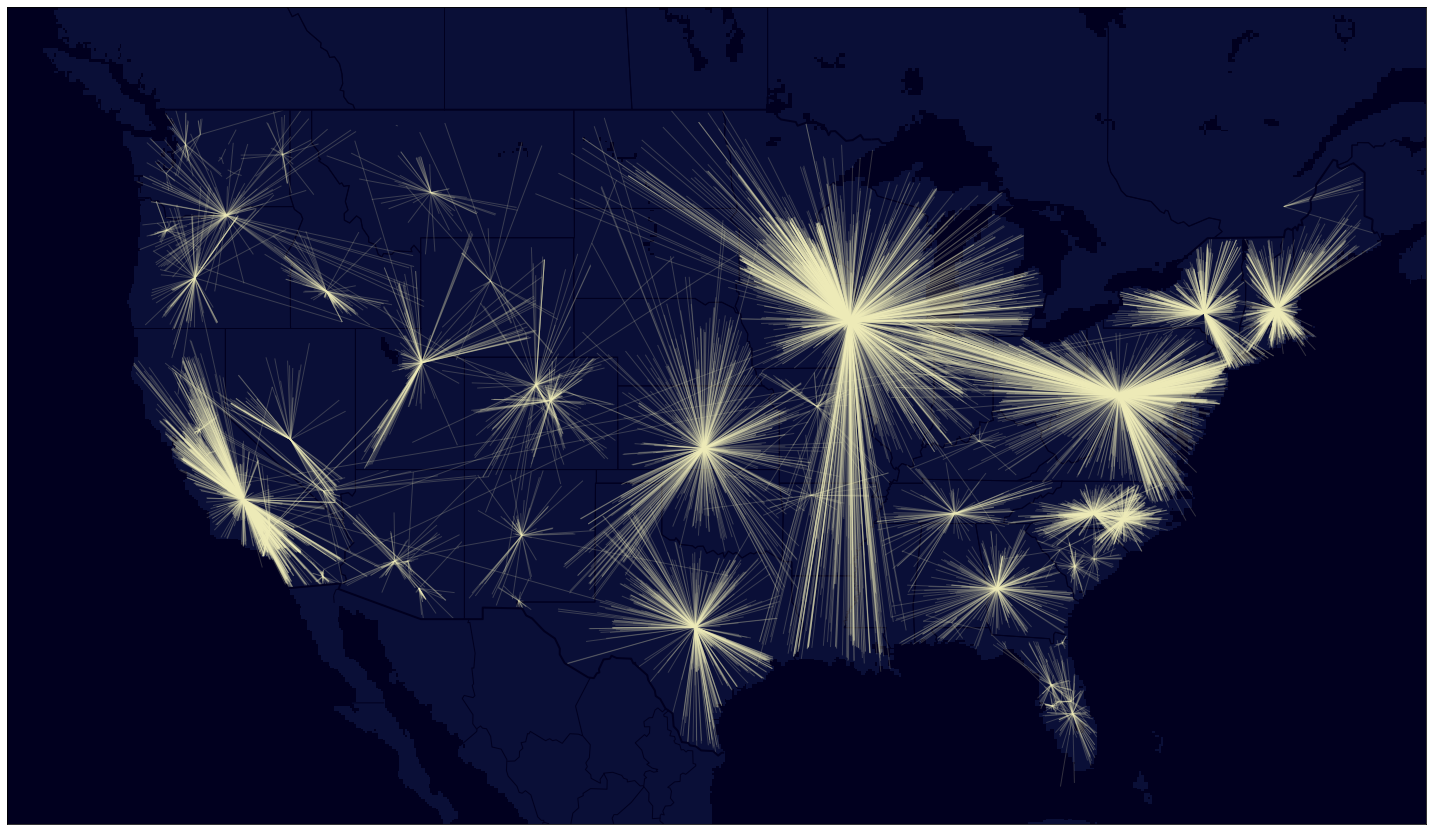

In [13]:
# Power Plants to Balancing Authorities
plt.figure(figsize=(20,20))

# Map properties
map.drawlsmask(land_color='#0a0f37', ocean_color='#01001f')
map.drawcountries(color='#01001f', linewidth=2)
map.drawstates(color='#01001f', linewidth=1, zorder=1)

# Draw edges
nx.draw_networkx_edges(G, pos, edgelist=plants_bas, edge_color='#f2efbc', arrows=False, alpha=0.2)

plt.tight_layout()

#### Balancing Authority Connections

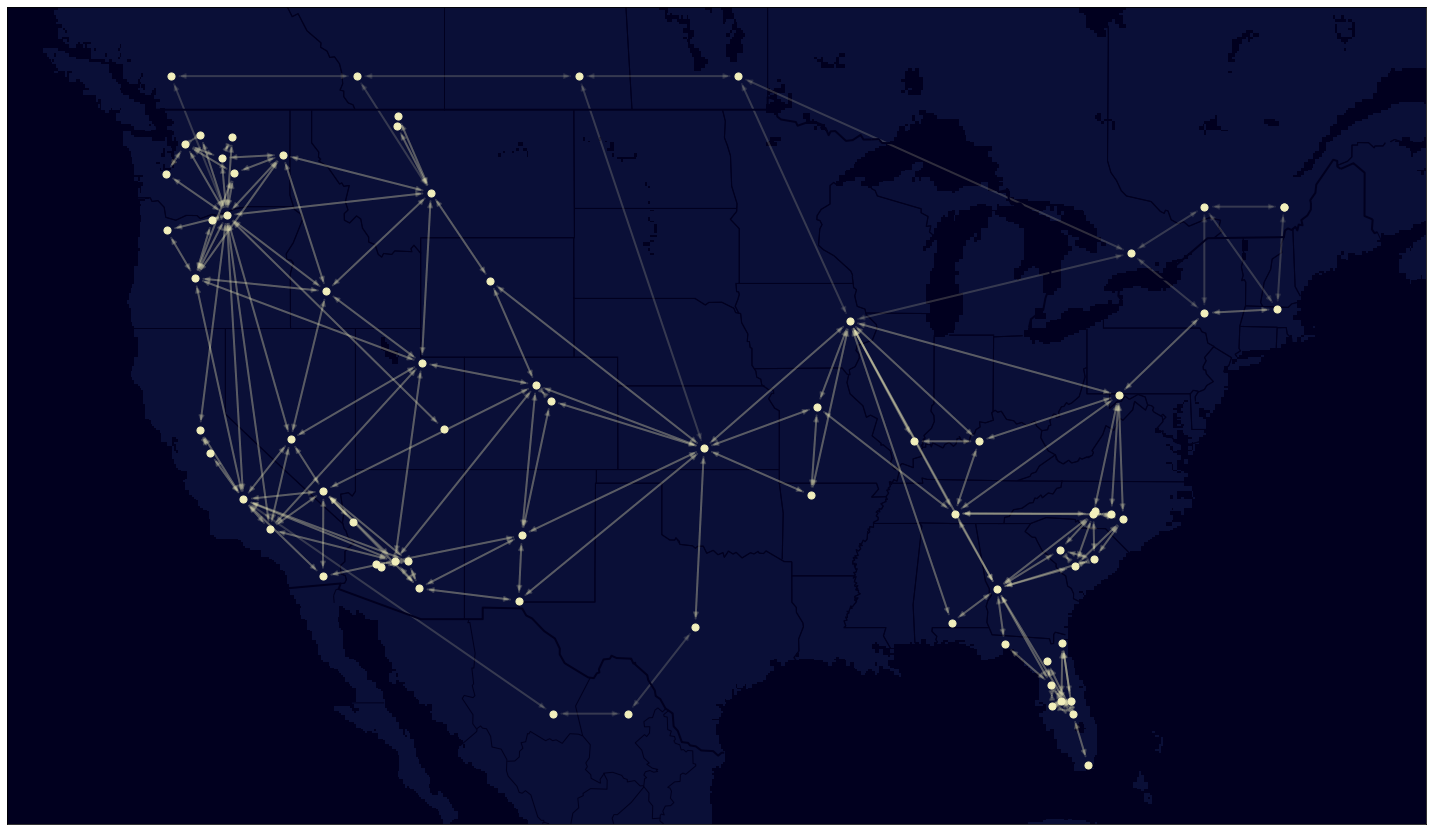

In [14]:
# Balancing Authorities to Balancing Authorities
plt.figure(figsize=(20,20))

# Map properties
map.drawlsmask(land_color='#0a0f37', ocean_color='#01001f')
map.drawcountries(color='#01001f', linewidth=2)
map.drawstates(color='#01001f', linewidth=1, zorder=1)

# Draw nodes and edges
nx.draw_networkx_nodes(G, pos, nodelist=ba_nodes, node_color='#f2efbc', node_size=50)
nx.draw_networkx_edges(G, pos, edgelist=bas_bas, edge_color='#f2efbc', width=2, alpha=0.1)

plt.tight_layout()

In [15]:
# Create a subgraph with Power Plants and Balancing Authorities
H = G.subgraph(plant_nodes + plants_bas + ba_nodes + bas_bas)

# Calculate clustering coefficient
plants_bas_coef = nx.clustering(H)

# Calculate degree centrality 
plants_bas_deg = nx.degree_centrality(H)

# The betweenness centrality for balancing authorities takes several minutes to
# run. As NetworkX performs this operation using a single thread, extra compute
# power does not necessarily speed it up. Based on this, it can be run
# by commenting out the code below, but it has also been pre-calculated
# and loaded.

# plants_bas_bet = nx.betweenness_centrality(H)
# with open('models/plants_bas_bet.pkl', 'wb') as f:
#     pickle.dump(plants_bas_bet, f)

# Combine centrality measures with original data set
bas['deg_cent'] = bas['ba_code'].astype(str).apply(lambda x: plants_bas_deg[x])
bas['bet_cent'] = bas['ba_code'].astype(str).apply(lambda x: plants_bas_bet[x])
bas['clust_coef'] = bas['ba_code'].astype(str).apply(lambda x: plants_bas_coef[x])

In [16]:
# Top 10 by degree centrality
cols = ['ba_code', 'ba_name', 'region_country_name', 'deg_cent']
bas.sort_values(by='deg_cent', ascending=False).head(10)[cols]

,ba_code,ba_name,region_country_name,deg_cent
33,MISO,"Midcontinent Independent System Operator, Inc.",Midwest,0.167168
40,PJM,"PJM Interconnection, LLC",Mid-Atlantic,0.136126
8,CISO,California Independent System Operator,California,0.108489
29,ISNE,ISO New England,New England,0.082040
36,NYIS,New York Independent System Operator,New York,0.056066
52,SWPP,Southwest Power Pool,Central,0.048385
13,DUK,Duke Energy Carolinas,Carolinas,0.040862
15,ERCO,"Electric Reliability Council of Texas, Inc.",Texas,0.037377
9,CPLE,Duke Energy Progress East,Carolinas,0.035002
49,SOCO,"Southern Company Services, Inc. - Trans",Southeast,0.025578


In [17]:
# Top 10 by betweenness centrality
cols = ['ba_code', 'ba_name', 'region_country_name', 'bet_cent']
bas.sort_values(by='bet_cent', ascending=False).head(10)[cols]

,ba_code,ba_name,region_country_name,bet_cent
33,MISO,"Midcontinent Independent System Operator, Inc.",Midwest,0.003064
52,SWPP,Southwest Power Pool,Central,0.002774
40,PJM,"PJM Interconnection, LLC",Mid-Atlantic,0.001431
49,SOCO,"Southern Company Services, Inc. - Trans",Southeast,0.001069
59,WACM,Western Area Power Administration - Rocky Moun...,Northwest,0.001031
8,CISO,California Independent System Operator,California,0.000812
35,NWMT,NorthWestern Corporation,Northwest,0.000789
36,NYIS,New York Independent System Operator,New York,0.000722
61,WAUW,Western Area Power Administration - Upper Grea...,Northwest,0.000721
6,BPAT,Bonneville Power Administration,Northwest,0.000690


In [18]:
# Top 10 by clustering coefficient
cols = ['ba_code', 'ba_name', 'region_country_name', 'clust_coef']
bas.sort_values(by='clust_coef', ascending=False).head(10)[cols]

,ba_code,ba_name,region_country_name,clust_coef
20,GLHB,GridLiance,Midwest,1.000000
66,HQT,Hydro-Quebec TransEnergie,Canada,0.500000
3,AVRN,"Avangrid Renewables, LLC",Northwest,0.500000
68,MHEB,Manitoba Hydro,Canada,0.333333
67,IESO,Ontario IESO,Canada,0.333333
12,DOPD,PUD No. 1 of Douglas County,Northwest,0.307692
19,GCPD,"Public Utility District No. 2 of Grant County,...",Northwest,0.258065
47,SEC,Seminole Electric Cooperative,Florida,0.216216
48,SEPA,Southeastern Power Administration,Southeast,0.206897
7,CHPD,Public Utility District No. 1 of Chelan County,Northwest,0.193548


## Enriched Output

In [19]:
plants.to_csv('data/processed/hifld/power_plants.csv', index=False)
subs.to_csv('data/processed/hifld/substations.csv', index=False)
lines.to_csv('data/processed/hifld/power_lines.csv', index=False)
bas.to_csv('data/processed/eia/balancing_authorities.csv', index=False)